# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['SHOOT', 'YESTERDAY', 'VEGETABLE', 'MARY', 'SEE', 'HOMEWORK', 'TELL', 'GO1', 'IX-1P', 'FRED', 'GIVE', 'BUY1', 'BROTHER', 'WANT', 'SOMETHING-ONE', 'HERE', 'PUTASIDE', 'LAST-WEEK', 'PEOPLE', 'WONT', 'VIDEOTAPE', 'MOVIE', 'WHAT', 'MANY', 'SHOULD', 'FUTURE', 'WHO', 'CHINA', 'GIRL', 'ARRIVE', 'GIVE2', 'CHICKEN', 'TOY1', 'ALL', 'CHOCOLATE', 'BROCCOLI', 'KNOW', 'FINISH', 'TEACHER', 'BUT', 'CHICAGO', 'COAT', 'SEARCH-FOR', 'READ', 'NAME', 'FUTURE1', 'GO2', 'GIVE3', 'NOT', 'BLUE', 'LEG', 'FIND', 'CORN', 'MOTHER', 'HOUSE', 'BLAME', 'CAR', 'BREAK-DOWN', 'VISIT', 'FISH', 'JOHN', 'STUDENT', 'TOMORROW', 'CORN1', 'PREFER', 'WILL', 'BORROW', 'BUY', 'WOMAN', 'THINK', 'PARTY', 'IX', 'LIVE', 'ANN', 'FRIEND', 'BOY', 'JANA', 'BILL', 'SELL', 'GO', 'NEW', 'THROW', 'SAY-1P', 'POTATO', 'GROUP', 'POSS', 'NEXT-WEEK', 'HAVE', 'OLD', 'DECIDE', 'CANDY', 'GIVE1', 'NEW-YORK', 'APPLE', 'FRANK', 'STOLEN', 'LIKE', 'CAN', 'GET', 'TOY', 'LEAVE', 'PAST', 'BOX', 'LOVE', 'WRITE', 'HIT', 'SELF', 'MAN', 'BOOK',

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['speaker'].map(df_means['right-x'])) / asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['speaker'].map(df_means['right-y'])) / asl.df['speaker'].map(df_std['right-y'])
asl.df['norm-lx'] = (asl.df['left-x']  - asl.df['speaker'].map(df_means['left-x']))  / asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly'] = (asl.df['left-y']  - asl.df['speaker'].map(df_means['left-y']))  / asl.df['speaker'].map(df_std['left-y'])

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

grnd_rx, grnd_ry = asl.df['grnd-rx'], asl.df['grnd-ry']
grnd_lx, grnd_ly = asl.df['grnd-lx'], asl.df['grnd-ly']

asl.df['polar-rr'] = np.hypot(grnd_rx, grnd_ry)
asl.df['polar-lr'] = np.hypot(grnd_lx, grnd_ly)
asl.df['polar-rtheta'] = np.arctan2(grnd_rx, grnd_ry)
asl.df['polar-ltheta'] = np.arctan2(grnd_lx, grnd_ly)

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
asl.df['delta-nx'] = asl.df['nose-x'].diff().fillna(0)
asl.df['delta-ny'] = asl.df['nose-y'].diff().fillna(0)
asl.df['dist-norm-x'] = asl.df['norm-lx'] - asl.df['norm-rx']
asl.df['dist-norm-y'] = asl.df['norm-ly'] - asl.df['norm-ry']

feature_delta_nose = ['delta-nx', 'delta-ny']
feature_dist_norm = ['dist-norm-x', 'dist-norm-y']

features_scaled = ['scaled-rx', 'scaled-ry', 'scaled-lx', 'scaled-ly', 'scaled-grx', 'scaled-gry', 'scaled-glx', 'scaled-gly']
for scaled, orign in zip(features_scaled, ['right-x', 'right-y', 'left-x', 'left-y', 'grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']):
    asl.df[scaled] = (asl.df[orign] - asl.df[orign].min()) / (asl.df[orign].max() - asl.df[orign].min())

# TODO define a list named 'features_custom' for building the training set
features_custom = feature_delta_nose + feature_dist_norm + features_scaled
asl.df[features_custom]

delta-nx  delta-ny  dist-norm-x  dist-norm-y  scaled-rx  \
video frame                                                            
98    0           0.0       0.0    -2.044431    -0.921597   0.655367   
      1           0.0       0.0    -2.044431    -0.921597   0.655367   
      2           0.0       0.0    -2.044431    -0.921597   0.655367   
      3           0.0       0.0    -2.044431    -0.921597   0.655367   
      4           0.0       0.0    -2.044431    -0.921597   0.655367   
      5           0.0       0.0    -2.044431    -0.921597   0.655367   
      6           0.0       0.0    -2.044431    -0.921597   0.655367   
      7           0.0       0.0    -2.044431    -0.921597   0.655367   
      8           0.0       0.0    -2.044431    -0.921597   0.655367   
      9           0.0       0.0    -2.044431    -0.921597   0.655367   
      10          0.0       0.0    -2.044431    -0.921597   0.655367   
      11          0.0       0.0    -1.983678    -0.863907   0.649718   
      12          0.0       0.0    -1.862171    -0.633145   0.638418   
      13          0.0       0.0    -1.801417    -0.488919   0.632768   
      14          0.0       0.0    -1.679910    -0.171622   0.621469   
      15          0.0       0.0    -1.315389     0.289902   0.587571   
      16          0.0       0.0    -1.011621     0.693735   0.559322   
      17          0.0       0.0    -0.221825     0.982187   0.485876   
      18          2.0      -4.0     0.628725     1.241794   0.406780   
      19          0.0       0.0     1.357768     1.414865   0.338983   
      20          0.0       0.0     1.600782     1.559092   0.316384   
      21         -1.0      -2.0     1.600782     1.559092   0.316384   
      22          0.0       0.0     1.297014     1.645627   0.344633   
      23          0.0       0.0     0.750232     1.732163   0.395480   
      24          0.0       0.0     0.567971     1.703318   0.412429   
      25          0.0      -2.0     0.264204     1.732163   0.440678   
      26          0.0       0.0     0.081943     1.761008   0.457627   
      27          0.0       0.0    -0.100318     1.847544   0.474576   
      28          0.0       0.0    -0.282578     1.962925   0.491525   
      29          0.0       0.0    -0.282578     1.962925   0.491525   
...               ...       ...          ...          ...        ...   
125   27          1.0       3.0     1.526803    -1.213651   0.508475   
      28          0.0       0.0     1.576008    -1.300186   0.519774   
      29          0.0       3.0     1.454501    -1.357877   0.531073   
      30          0.0       0.0     1.636761    -1.444412   0.514124   
      31          0.0       0.0     2.042789    -1.473258   0.502825   
      32          0.0       0.0     1.917432    -1.395478   0.519774   
      33          0.0       0.0     1.917432    -1.280097   0.519774   
      34          0.0       0.0     2.088144    -1.089513   0.519774   
      35          0.0       0.0     2.156597    -1.025642   0.502825   
      36         -1.0       3.0     2.156597    -1.025642   0.502825   
      37          0.0       0.0     1.466049    -1.224983   0.514124   
      38          0.0       0.0     0.471734    -1.473258   0.553672   
      39          0.0      -1.0     0.008802    -1.363028   0.564972   
      40          1.0      -3.0     0.008802    -1.363028   0.564972   
      41         -1.0       0.0     0.008802    -1.363028   0.564972   
      42          0.0       0.0     0.008802    -1.363028   0.564972   
      43         -1.0      -1.0     0.008802    -1.363028   0.564972   
      44          0.0      -5.0    -0.051951    -1.363028   0.570621   
      45          0.0       0.0    -0.051951    -0.911807   0.570621   
      46          0.0       0.0    -0.283417    -0.717618   0.576271   
      47          0.0       0.0    -0.575636    -0.332844   0.587571   
      48          0.0       0.0    -0.757897    -0.034606   0.604520   
      49          0.0       0.0    -1.338486    -0.01

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 

I added the nose movement (delta nose), the normalized distance of the hands, the scaled position and the grounded scaled position.

In the training set, the speaker moves the nose with the same movement for the same sentence, that means that the node movement has a mean.

The other features are just more precise information about the hands movements. Using just the ground information doesn't provide a good match for the recognition, because there is some different between speakers. A scaled information is more precise than a not scaled.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

# features_ground                   & 3  -> logL = -2331.1138127433205
# features_ground                   & 12 -> logL = -1786.3869146836516
# features_delta                    & 3  -> logL = -663.7695656348735
# features_norm                     & 3  -> logL = -130.7108922194024
# features_polar                    & 3  -> logL = -901.0844114013488
# features_polar                    & 12 -> logL = -491.32695928225274
# features_norm + features_polar    & 3  -> logL = -1084.9811345138523
# features_norm + features_polar    & 12 -> logL = -269.73340944640324
# features_delta + features_polar   & 3  -> logL = -2725.8801749402974
# feature_delta_nose                & 3  -> logL = 1005.9939200192468
# feature_dist_norm                 & 3  -> logL = -23.929701908239444
# feature_dist_norm + features_norm & 3  -> logL = -195.72955039365866
# features_scaled                   & 3  -> logL = 2447.5789688459204
# features_custom                   & 3  -> logL = 2941.1690691644358
# features_custom                   & 12 -> logL = 3332.1343933451735

demoword = 'BOOK'
model, logL = train_a_word(demoword, 12, features_polar)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 12
logL = -475.4925009271996


/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 12
hidden state #0
mean =  [4.87956091e+01 3.36117203e-02 5.50886909e+01 3.11910468e-01]
variance =  [1.65006152e+01 2.38808303e-03 2.62520949e+01 2.13892263e-03]

hidden state #1
mean =  [ 9.37022205e+01 -4.83730746e-02  1.00950945e+02  1.83830473e-01]
variance =  [1.38180246e+01 9.50830472e-03 1.54071844e+00 2.37556452e-03]

hidden state #2
mean =  [ 7.01124894e+01 -2.63537011e-03  7.93520617e+01  2.12102035e-01]
variance =  [9.86868455e+00 2.80090636e-03 1.03977664e+01 3.43220079e-03]

hidden state #3
mean =  [ 88.27270981  -0.16720328 100.6092222    0.18444746]
variance =  [7.65467489e+00 8.31266513e-03 2.61689815e+01 7.93843376e-03]

hidden state #4
mean =  [55.49086869 -0.11356281 56.70394332  0.18501248]
variance =  [2.29803588 0.0052235  4.5655254  0.00487583]

hidden state #5
mean =  [60.10303779 -0.08972871 63.09448081  0.27504875]
variance =  [6.72985359e+00 8.88082801e-03 5.62061386e+00 6.17778259e-03]

hidden state #6
mean =  [

##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 8, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 8
hidden state #0
mean =  [ 8.20548597e+01 -3.65690559e-02  9.70154627e+01  1.44812498e-01]
variance =  [0.005 0.005 0.005 0.005]

hidden state #1
mean =  [ 6.37831471e+01 -8.89405822e-02  8.33402666e+01  2.16916053e-02]
variance =  [9.52662702e+00 2.01582590e-03 1.91211875e-01 1.26594364e-03]

hidden state #2
mean =  [ 5.52968756e+01 -7.41697042e-02  9.04696801e+01  4.52487602e-02]
variance =  [9.89154367e+00 3.56747959e-03 6.86516707e+01 3.12925502e-03]

hidden state #3
mean =  [52.62385337 -0.15731308 69.26037828  0.08673834]
variance =  [1.28499427e+00 4.36527651e-03 1.11112339e-03 1.11112339e-03]

hidden state #4
mean =  [ 9.61664990e+01 -1.08144698e-01  1.32091327e+02  9.47412810e-02]
variance =  [8.85452862e+00 6.91218433e-03 1.24964348e+01 5.00108146e-03]

hidden state #5
mean =  [ 4.98065991e+01 -1.48596168e-01  1.11103866e+02  3.38331035e-02]
variance =  [2.66900987e+00 7.80804290e-03 4.93396523e+01 5.55185673e-03]

hidden st

/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/victor/anaconda3/envs/aind-universal/lib/python3.5/site-packages/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [19]:
%matplotlib inline

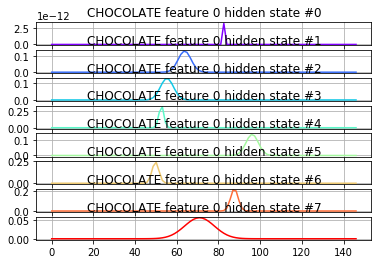

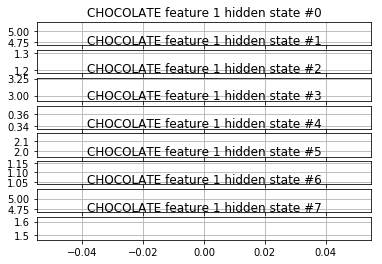

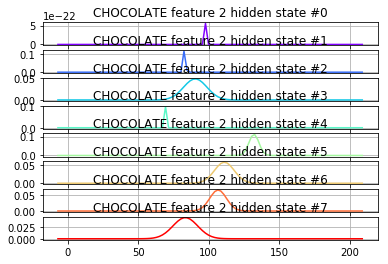

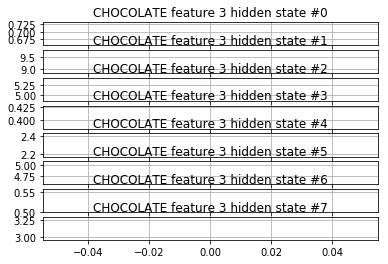

In [20]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [21]:
from my_model_selectors import SelectorConstant
from my_model_selectors import SelectorBIC
from my_model_selectors import SelectorDIC

# VEGETABLE && features_ground                  && DIC -> 10
# VEGETABLE && features_ground                  && BIC -> 9

# CAR       && features_ground                  && DIC -> 10
# CAR       && features_ground                  && BIC -> 5

# CAR       && features_scaled                  && DIC -> 10
# CAR       && features_scaled                  && BIC -> 6

# CAR       && features_delta + features_scaled && DIC -> 8
# CAR       && features_delta + features_scaled && BIC -> 5

# CAR       && features_delta                   && DIC -> 9
# CAR       && features_delta                   && BIC -> 5

# CAR       && features_norm                    && DIC -> 9
# CAR       && features_norm                    && BIC -> 4

# CAR       && features_polar                   && DIC -> 10
# CAR       && features_polar                   && BIC -> 6
training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
word = 'CAR' # Experiment here with different words
model = SelectorDIC(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CAR is 10


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold

training = asl.build_training(features_norm) # Experiment here with different feature sets
word = 'ARRIVE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[ 5  6  7  8  9 10 11 12 13 14] Test fold indices:[0 1 2 3 4]
Train fold indices:[ 0  1  2  3  4 10 11 12 13 14] Test fold indices:[5 6 7 8 9]
Train fold indices:[0 1 2 3 4 5 6 7 8 9] Test fold indices:[10 11 12 13 14]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [25]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

# features_ground 
#      Training complete for FISH with 14 states with time 0.6475031139998464 seconds
#      Training complete for BOOK with 14 states with time 4.926649740000357 seconds
#      Training complete for VEGETABLE with 14 states with time 2.2279935050009954 seconds
#      Training complete for FUTURE with 14 states with time 5.390197100001387 seconds
#      Training complete for JOHN with 14 states with time 43.99032529000033 seconds

# features_norm
#      Training complete for FISH with 14 states with time 0.6141172229999938 seconds
#      Training complete for BOOK with 14 states with time 5.234704896000039 seconds
#      Training complete for VEGETABLE with 14 states with time 2.4470515430002706 seconds
#      Training complete for FUTURE with 14 states with time 5.239069627999925 seconds
#      Training complete for JOHN with 14 states with time 49.72371820599983 seconds

# features_norm + features_ground
#      Training complete for FISH with 14 states with time 0.6322960990000865 seconds
#      Training complete for BOOK with 14 states with time 4.8068477580000035 seconds
#      Training complete for VEGETABLE with 14 states with time 3.1249738149999757 seconds
#      Training complete for FUTURE with 14 states with time 5.002166356000089 seconds
#      Training complete for JOHN with 14 states with time 45.97932697300166 seconds

# features_norm + features_ground + features_scaled
#      Training complete for FISH with 14 states with time 0.7238767580001877 seconds
#      Training complete for BOOK with 14 states with time 5.412048455000331 seconds
#      Training complete for VEGETABLE with 14 states with time 7.17227296800047 seconds
#      Training complete for FUTURE with 14 states with time 3.937727888000154 seconds
#      Training complete for JOHN with 14 states with time 43.79369113700159 seconds

# features_delta
#      Training complete for FISH with 14 states with time 0.6264021850001882 seconds
#      Training complete for BOOK with 14 states with time 3.327645544999541 seconds
#      Training complete for VEGETABLE with 14 states with time 1.3980982479988597 seconds
#      Training complete for FUTURE with 14 states with time 2.3295838519989047 seconds
#      Training complete for JOHN with 14 states with time 31.154838197999197 seconds

# features_polar
#      Training complete for FISH with 14 states with time 0.7693621239995991 seconds
#      Training complete for BOOK with 14 states with time 3.3512828999992053 seconds
#      Training complete for VEGETABLE with 14 states with time 2.2439136949979 seconds
#      Training complete for FUTURE with 14 states with time 3.2878806490007264 seconds
#      Training complete for JOHN with 14 states with time 28.27324682499966 seconds


training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 14 states with time 0.6314155920117628 seconds
Training complete for BOOK with 14 states with time 3.4486070760031 seconds
Training complete for VEGETABLE with 14 states with time 1.7384022619953612 seconds
Training complete for FUTURE with 14 states with time 2.160454701996059 seconds
Training complete for JOHN with 14 states with time 28.564919304000796 seconds


In [26]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

# features_ground
#      Training complete for FISH with 5 states with time 0.49352874199939833 seconds
#      Training complete for BOOK with 8 states with time 2.69901513700097 seconds
#      Training complete for VEGETABLE with 9 states with time 0.8728999579998344 seconds
#      Training complete for FUTURE with 9 states with time 2.7769973880003818 seconds
#      Training complete for JOHN with 13 states with time 21.799064328000895 seconds

# features_norm
#      Training complete for FISH with 2 states with time 0.6585630570007197 seconds
#      Training complete for BOOK with 5 states with time 2.791547733999323 seconds
#      Training complete for VEGETABLE with 5 states with time 1.1614271180005744 seconds
#      Training complete for FUTURE with 7 states with time 3.0086712500014983 seconds
#      Training complete for JOHN with 15 states with time 20.904339048998736 seconds

# features_norm + features_ground
#      Training complete for FISH with 5 states with time 0.5641585079993092 seconds
#      Training complete for BOOK with 7 states with time 2.363757903000078 seconds
#      Training complete for VEGETABLE with 9 states with time 1.3547296140004619 seconds
#      Training complete for FUTURE with 9 states with time 1.7832289509988186 seconds
#      Training complete for JOHN with 14 states with time 24.619292287999997 seconds

# features_norm + features_ground + features_scaled
#      Training complete for FISH with 3 states with time 0.6290165020000131 seconds
#      Training complete for BOOK with 7 states with time 2.908226625999305 seconds
#      Training complete for VEGETABLE with 3 states with time 9.137943310999617 seconds
#      Training complete for FUTURE with 6 states with time 2.799960042000748 seconds
#      Training complete for JOHN with 15 states with time 26.331231665000814 seconds

# features_delta
#      Training complete for FISH with 4 states with time 0.5084580220009229 seconds
#      Training complete for BOOK with 8 states with time 3.9523198980004963 seconds
#      Training complete for VEGETABLE with 3 states with time 1.2894424109999818 seconds
#      Training complete for FUTURE with 5 states with time 2.5849198539999634 seconds
#      Training complete for JOHN with 6 states with time 27.921026300999074 seconds

# features_polar
#      Training complete for FISH with 2 states with time 0.5716580190000968 seconds
#      Training complete for BOOK with 7 states with time 3.3084046259991737 seconds
#      Training complete for VEGETABLE with 3 states with time 1.152795984999102 seconds
#      Training complete for FUTURE with 4 states with time 2.8146203710002737 seconds
#      Training complete for JOHN with 11 states with time 32.3009827249989 seconds

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.5101732990005985 seconds
Training complete for BOOK with 7 states with time 2.7371294850017875 seconds
Training complete for VEGETABLE with 3 states with time 1.1038958669960266 seconds
Training complete for FUTURE with 4 states with time 2.768304031997104 seconds
Training complete for JOHN with 11 states with time 27.47268107299169 seconds


In [27]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

# features_ground
#      Training complete for FISH with 3 states with time 0.9779277229990839 seconds
#      Training complete for BOOK with 15 states with time 5.0102797189993 seconds
#      Training complete for VEGETABLE with 15 states with time 3.5288996970011794 seconds
#      Training complete for FUTURE with 15 states with time 4.816219443000591 seconds
#      Training complete for JOHN with 15 states with time 27.279508345998693 seconds

# features_norm
#      Training complete for FISH with 2 states with time 3.060505610999826 seconds
#      Training complete for BOOK with 15 states with time 5.026980925000316 seconds
#      Training complete for VEGETABLE with 5 states with time 3.656626871001208 seconds
#      Training complete for FUTURE with 15 states with time 5.128921525001715 seconds
#      Training complete for JOHN with 15 states with time 24.938907383000696 seconds

# features_norm + features_ground
#      Training complete for FISH with 3 states with time 1.7938732220009115 seconds
#      Training complete for BOOK with 15 states with time 6.398562222999317 seconds
#      Training complete for VEGETABLE with 15 states with time 4.373554466999849 seconds
#      Training complete for FUTURE with 15 states with time 5.8314606830008415 seconds
#      Training complete for JOHN with 15 states with time 28.01980719200037 seconds

# features_norm + features_ground + features_scaled
#      Training complete for FISH with 7 states with time 1.609065227999963 seconds
#      Training complete for BOOK with 15 states with time 4.3226536299989675 seconds
#      Training complete for VEGETABLE with 15 states with time 10.835753049999767 seconds
#      Training complete for FUTURE with 15 states with time 4.453350767000302 seconds
#      Training complete for JOHN with 15 states with time 28.625605275999987 seconds

# features_delta
#      Training complete for FISH with 4 states with time 1.4997690290001628 seconds
#      Training complete for BOOK with 15 states with time 8.547644230000515 seconds
#      Training complete for VEGETABLE with 2 states with time 4.691688984999928 seconds
#      Training complete for FUTURE with 5 states with time 3.558947829000317 seconds
#      Training complete for JOHN with 15 states with time 32.75652503500169 seconds

# features_polar
#      Training complete for FISH with 2 states with time 3.4184442390014738 seconds
#      Training complete for BOOK with 14 states with time 5.197931390001031 seconds
#      Training complete for VEGETABLE with 12 states with time 3.5657681029988453 seconds
#      Training complete for FUTURE with 14 states with time 4.9819106590002775 seconds
#      Training complete for JOHN with 15 states with time 31.58552802200029 seconds

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 3.0713816130009945 seconds
Training complete for BOOK with 14 states with time 4.8651073619985254 seconds
Training complete for VEGETABLE with 12 states with time 3.501149689007434 seconds
Training complete for FUTURE with 14 states with time 4.44087157100148 seconds
Training complete for JOHN with 15 states with time 29.236653671003296 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

### BIC 

#### Advantages:

 * Penalizes complex models avoind overfit
 
#### Disadvantages

 * As BIC penalizes complex models, so DIC works better for more states
 * BIC assumes that one of the models it is using is true and that you are trying to find the model most likely to be true in the Bayesian sense (Wasserman lecture notes). If the true models doesn’t exist in comparison, if the real evaluation is non-bayesian, or if high model complexity is permissable, then it is not a good measure.

### DIC

#### Advantages:
 
 * DIC has some advantages over BIC, it reduces the relative error rate. [2]
 * It is a more complex information
 * DIC can generate more complex
 
 
#### Disadvantages

 * DIC has some theoretical limitations, in that its penalty term is invariant to reparameterization, lacks consistency, and isn’t based on a proper predictive criterion.

### CV

#### Advantages:

 * If the dataset has a good representation of all possible, it will create the most accurate representation.
 
#### Disadvantages
 
 * Do not penalize complex models, this can leads to overfit. In our tests CV always choose a model with more states than BIC and DIC
 * CV is more expanse to calculate than BIC and DIC because it will run over a set of configurations

See: 
 1. https://stites.io/posts/2017-10-09-bic-dic-cv.html
 2. https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [28]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 47.745s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [29]:
from my_model_selectors import SelectorConstant
from my_model_selectors import SelectorDIC

# features_ground                  -> 112
# features_ground + features_delta -> 112
# features_polar                   -> 112

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_polar, SelectorDIC)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [30]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [31]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [32]:
# feature=features_ground	model_selector=SelectorBIC
# **** WER = 0.550561797752809
# Total correct: 80 out of 178

# feature=features_ground	model_selector=SelectorDIC
# **** WER = 0.5786516853932584
# Total correct: 75 out of 178

# feature=features_ground	model_selector=SelectorCV
# **** WER = 0.5786516853932584
# Total correct: 75 out of 178

# feature=features_polar	model_selector=SelectorBIC
# **** WER = 0.5393258426966292
# Total correct: 82 out of 17

# feature=features_polar	model_selector=SelectorDIC
# **** WER = 0.5449438202247191
# Total correct: 81 out of 178

# feature=features_polar	model_selector=SelectorCV
# **** WER = 0.5337078651685393
# Total correct: 83 out of 178

# feature=features_delta	model_selector=SelectorBIC
# **** WER = 0.6179775280898876
# Total correct: 68 out of 178

# feature=features_delta	model_selector=SelectorDIC
# **** WER = 0.6573033707865169
# Total correct: 61 out of 178

# feature=features_delta	model_selector=SelectorCV
# **** WER = 0.6460674157303371
# Total correct: 63 out of 178

# feature=features_norm	model_selector=SelectorBIC
# **** WER = 0.6123595505617978
# Total correct: 69 out of 178

# feature=features_norm	model_selector=SelectorDIC
# **** WER = 0.6235955056179775
# Total correct: 67 out of 178

# feature=features_norm	model_selector=SelectorCV
# **** WER = 0.5842696629213483
# Total correct: 74 out of 178

models = train_all_words(features_polar, SelectorCV)
test_set = asl.build_test(features_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *ARRIVE *GIVE1                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE *WHO BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN *IX *ARRIVE                                          JOHN CAN GO CAN
  201: JOHN *MARY *WOMAN *LOVE BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT VISIT MARY                                         JOHN NOT VISIT MARY
  119: *VISIT *ARRIVE IX *JOHN *IX                                   SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [33]:
models = train_all_words(features_polar, SelectorBIC)
test_set = asl.build_test(features_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
  201: JOHN *MAN *MAN *LIKE BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *CAR CAR *IX                                    SUE BUY IX CAR BLUE
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [34]:
models = train_all_words(features_polar, SelectorDIC)
test_set = asl.build_test(features_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
   67: JOHN FUTURE *MARY BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
  201: JOHN *MARY *WOMAN *JOHN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *GO *GO MARY                                              JOHN NOT VISIT MARY
  119: *MARY *LOVE IX *BLAME *IX                                     SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

For the test it is only considered the features set:
 * features_groud
 * features_polar
 * features_delta
 * features_norm
 
Executing all possible configuration with just one set of features returned the following values:

| Feature Set | Model Selector | Correct Words | WER |
|-------------|----------------|---------------|-----|
|features_ground|SelectorBIC|80|0.550561797752809|
|features_ground|SelectorDIC|75|0.5786516853932584|
|features_ground|SelectorCV|75|0.5786516853932584|
|features_polar|SelectorBIC|82|0.5393258426966292|
|features_polar|SelectorDIC|81|0.5449438202247191|
|features_polar|SelectorCV|83|0.5337078651685393|
|features_delta|SelectorBIC|68|0.6179775280898876|
|features_delta|SelectorDIC|61|0.6573033707865169|
|features_delta|SelectorCV|63|0.6460674157303371|
|features_norm|SelectorBIC|69|0.6123595505617978|
|features_norm|SelectorDIC|67|0.6235955056179775|
|features_norm|SelectorCV|74|0.5842696629213483|
|ALL|SelectorCV|79|0.5561797752808989|
|ALL|SelectorDIC|89|0.5|
|ALL|SelectorBIC|93|0.47752808988764045|
|features_custom|SelectorBIC|90|0.4943820224719101|
|features_custom|SelectorDIC|73|0.5898876404494382|
|features_custom|SelectorCV|63|0.6460674157303371|


To select the best value, we can order all configuration using the value of **WER**, or the value of corrected words.
The best values are:

 1. features_polar SelectorCV
 2. features_polar SelectorBIC
 3. features_polar SelectorDIC
 
The reduction of the **WER** can be achieved by selecting a good set of features. As we could see in the tests, the trainned model doesn't recognize some words, this occurs, probably, because the words are not well represented by the features. In the results above, the test with bigger feature set has a lower **WER**. 

Another way to reduce the **WER** is add the hand configuration to the features. Our ASL Recognizer doesn't undestand if the hand is closed or open, if the thumb is open or closed, but this information is important to the recognize, as we can see in any [ASL word list](https://www.startasl.com/basic-words-in-sign-language_html)
 
The use of scaled featuers shows a great improve to the correctness of the results only with BIC model selectors. 

The addition of *n-gram* information to the recognition doesn't improve the correctness of the result. This occurrs because the *n-gram* grammar of ASL is much more simple than the english grammar. For example, in pure english it is know that before some words it is accept only some pronoums.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [35]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 97.230s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [36]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2668.230407,-1.754238e+05,-3821.731798,-433.372357,-2021.376512,-486.090611,-2977.186098,-1143.793180,-4598.676525,-761.934722,...,-1972.204146,-314.252247,-2.827032e+05,-380.658448,-313.271105,-1370.925033,-785.026980,-858.711162,-3.449779e+05,-404.967285
1,-6895.768882,-1.629015e+06,-9913.062801,-221.028322,-20390.517616,-545.200614,-8074.012572,-215.545223,-4302.906985,-656.173152,...,-287.510561,-651.959734,-4.369099e+04,-444.342955,-213.323807,-4850.393361,-2231.097747,-1598.082952,-2.185715e+05,-699.452636
2,-9583.371739,-2.520513e+06,-16079.924329,-323.626848,-30781.026548,-920.973313,-11682.524097,-892.662877,-3884.198816,-1218.176901,...,-977.333976,-800.111435,-5.568921e+05,-765.571340,-488.986094,-7248.523564,-2094.696327,-1875.846818,-1.741162e+05,-1434.391979
3,-1165.277459,-2.940998e+06,-2659.745691,-382.501303,-697.132008,-359.142220,-670.882087,-1273.873850,-34002.165541,-815.160915,...,-5204.389030,-652.763688,-1.143353e+06,-843.899146,-666.818036,-11965.545380,-464.841003,-722.328183,-2.441833e+06,-624.661118
4,-1566.626739,-6.624793e+05,-3216.817439,-201.856929,-3448.141154,-160.899898,-742.442304,-266.893421,-950.645737,-152.404923,...,-1059.684629,-168.573270,-6.012152e+05,-153.207835,-310.477503,-5605.827539,-562.681398,-916.457328,-3.654031e+05,-589.423174


In [37]:
# We are using the arpa to read the n-gram file
# the only change is that it should replace [UNKNOW] tag by <unk>

import arpa
from asl_data import SinglesData

lm_models = arpa.loadf("asl.lm")

def score_lm(word, last_words):
    try:
        return lm_models[0].log_s(' '.join(last_words + [word]))
    except:
        return lm_models[0].log_s(' '.join(last_words + ['<unk>']))

def end_of_sentence(sentences_index, index):
    for _, index_list in sentences_index.items():
        if index in index_list:
            return index_list.index(index) + 1 == len(index_list)
    return False

def recognize(models: dict, test_set: SinglesData):
    """ Recognize test word sequences from word models set

   :param models: dict of trained models
       {'SOMEWORD': GaussianHMM model object, 'SOMEOTHERWORD': GaussianHMM model object, ...}
   :param test_set: SinglesData object
   :return: (list, list)  as probabilities, guesses
       both lists are ordered by the test set word_id
       probabilities is a list of dictionaries where each key a word and value is Log Liklihood
           [{SOMEWORD': LogLvalue, 'SOMEOTHERWORD' LogLvalue, ... },
            {SOMEWORD': LogLvalue, 'SOMEOTHERWORD' LogLvalue, ... },
            ]
       guesses is a list of the best guess words ordered by the test set word_id
           ['WORDGUESS0', 'WORDGUESS1', 'WORDGUESS2',...]
   """
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    probabilities = []
    guesses = []
    recog_sentence = ['<s>']
    for index, (X, lengths) in test_set.get_all_Xlengths().items():
        best_score, best_guess, word_probability = float("-inf"), "", {}

        for model_word, model in models.items():
            prob = float("-inf")
            try:
                # As we are sum log, we are multpling probabilities
                prob = model.score(X, lengths) + score_lm(model_word, recog_sentence[-2:])
            except:
                pass
            word_probability[model_word] = prob

            if prob > best_score:
                best_score, best_guess = prob, model_word

        #if test_set.wordlist[index] != best_guess:
        #    print('WRONG WORD: {} != {} {}'.format(best_guess, test_set.wordlist[index], best_score))
        #    print(word_probability)

        guesses.append(best_guess)
        recog_sentence.append(best_guess)
        probabilities.append(word_probability)
        if end_of_sentence(test_set.sentences_index, index):
            recog_sentence = ['<s>']


    return probabilities, guesses